<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter17/ControlNet-Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install -Uqq fastdownload torch-snippets diffusers accelerate

In [ ]:
from fastdownload import download_url
from torch_snippets import *

In [ ]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/4/44/Man_in_red_shirt_and_black_jacket_staring_into_camera.jpg -O MyImage.jpg
dest = 'MyImage.jpg'

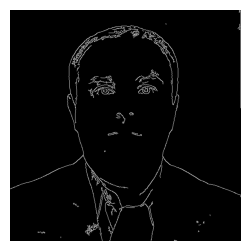

In [ ]:
image0 = read(dest)
low_threshold = 10
high_threshold = 250

image = cv2.Canny(image0, low_threshold, high_threshold)
image = image[:, :, None]
canny_image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(canny_image)
show(canny_image, sz=3)
canny_image.save('canny.png')

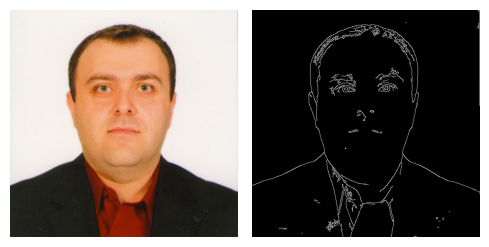

In [ ]:
subplots([image0, canny_image])

In [ ]:
image.shape

(600, 600, 1)

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch

In [ ]:
import cv2
from PIL import Image
image = cv2.imread('/content/canny.png')
canny_image = Image.fromarray(image)

In [ ]:
generator = torch.Generator(device='cuda').manual_seed(12345)
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [ ]:
from diffusers import DPMSolverMultistepScheduler

In [ ]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet
).to('cuda')

# change the scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# enable xformers (optional), requires xformers installation
# pipe.enable_xformers_memory_efficient_attention()
# # cpu offload for memory saving, requires accelerate>=0.17.0
# pipe.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
pipe

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.28.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
image = pipe(
    "a man with beard, realistic, high quality",
    negative_prompt="cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, blurry, bad anatomy, bad proportions, nsfw",
    num_inference_steps=25,
    generator=generator,
    image=canny_image,
    controlnet_conditioning_scale=0.5

).images[0]
image.save('output.png')

  0%|          | 0/25 [00:00<?, ?it/s]

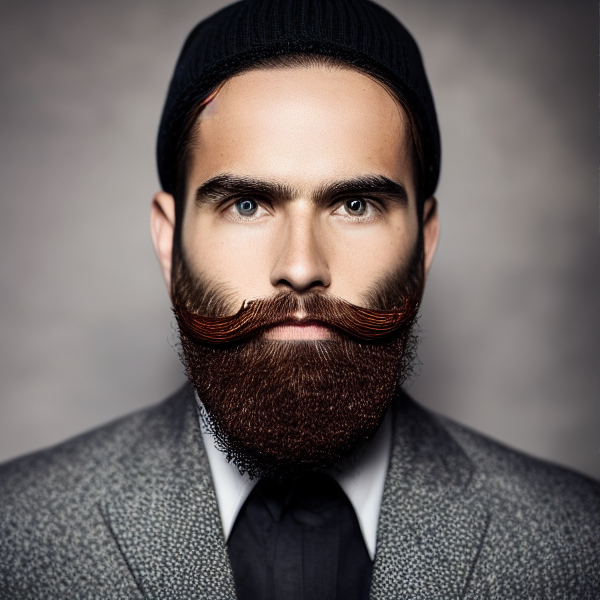

In [ ]:
image

# Explanation

Controlnet is a system of unets to control the output of stable diffusion using an input image with a specific, predefined shape/outline/depth-map/pose or any such abstract concepts that define the broader requirement of the output.
Techinically speaking, controlnet has the (near) exact architecture of unet2d of stable diffusion and the outputs from downblocks and midblocks of the control net are passed as additional inputs to the upblocks of stable-diffusion's unet2d.
The overall inputs for a controlnet system are
1. text prompt
2. control image
3. number of inference steps, and optionally a
4. negative text prompt (for guiding the output image away from negative concepts)

The output is an image that reflects the text as well as the control image

E.g.
(From huggingface controlnet blog - )

Text Prompt = "super-hero character, best quality, extremely detailed"

Control Image =
![](https://huggingface.co/datasets/YiYiXu/test-doc-assets/resolve/main/blog_post_cell_28_output_0.jpeg)
Output =
![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/anime_do_yoga.png)

Notebook - https://colab.research.google.com/drive/1Txjb2lN6bAkMOL-6FXjybCHHOT3GC-Hz
## Code

Define the __call__ method with parameters like prompt, image, height, and more. These parameters allow you to control various aspects of the image generation process.
```python
def __call__(...):
```

---

Initialize the variables
```python
controlnet = self.controlnet
self.check_inputs(...)
if prompt is not None and isinstance(prompt, str):
    batch_size = 1
device = self._execution_device
do_classifier_free_guidance = guidance_scale > 1.0
global_pool_conditions = ...
guess_mode = guess_mode or global_pool_conditions
```

---

Generate embeddings for the prompt and negative prompt using the encode_prompt method.
```python
prompt_embeds, negative_prompt_embeds = self.encode_prompt(
	prompt,
	device,
	num_images_per_prompt,
	do_classifier_free_guidance,
	negative_prompt,
	prompt_embeds=prompt_embeds,
	negative_prompt_embeds=negative_prompt_embeds,
)
```

---

If classifier-free guidance is enabled, concatenate the negative prompt and prompt embeddings. We'll discuss what is classifier free guidance in a moment
```python
if do_classifier_free_guidance:
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
```

---

Prepare the input image with the given dimensions and extract its height and width.
```python
image = self.prepare_image(...)
```

---

Configure the diffusion process scheduler with the specified number of inference steps.
```python
self.scheduler.set_timesteps(num_inference_steps, device=device)
```

---

Prepare the initial latent variables necessary for starting the image generation process.
```python
latents = self.prepare_latents(...)
```

---

Execute a loop over each timestep, using a progress bar to monitor the progress. Update the latent variables and apply various transformations to generate the image within this loop.
```python
for i, t in enumerate(...):
    ...
```


---

Inside the loop,

First, prepare the latents of the images (by doubling the images if we are about to do classifier free guidance)
```python
	...
	latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
	latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
	control_model_input = latent_model_input
	controlnet_prompt_embeds = prompt_embeds
```

---

Extract the outputs from all the downblock layers as well as midblock layers using the control net. Send these outputs along with the noisy-latents and timesteps to the actual unet. Internally the unet combines the outputs from its own downblock and midblock layers with those coming from controlnet before performing the upblock operations. See the image below. The role zero convolutions are part of control net training and are not important for this section. The reader is advised to read further and see what is the role of these blocks.
```python
	...
	down_block_res_samples, mid_block_res_sample = self.controlnet(
		control_model_input,
		t,
		encoder_hidden_states=controlnet_prompt_embeds,
		controlnet_cond=image,
		conditioning_scale=controlnet_cond_scale,
		guess_mode=guess_mode,
		return_dict=False,
	)
	# predict the noise residual
	noise_pred = self.unet(
		latent_model_input,
		t,
		encoder_hidden_states=prompt_embeds,
		cross_attention_kwargs=cross_attention_kwargs,
		down_block_additional_residuals=down_block_res_samples,
		mid_block_additional_residual=mid_block_res_sample,
		return_dict=False,
	)[0]
```

![](https://i.imgur.com/hw5R80E.png)

---

During classfier free guidance, the predicted image for the positive prompt, let's call it $\vec{b}$ and the predicted image for the negative prompt $\vec{a}$ are used in such a way that the final output is far away from the negative prompt and closer to the positive prompt.
```python
	...
	if do_classifier_free_guidance:
		noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
		# noise_pred_uncond - Negative prompt's noise
		# noise_pred_text - prompt's text
		noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
```

$$noise\_pred = \vec{a} + cfg*(\vec{b}-\vec{a})$$

![](https://i.imgur.com/COPSgzM.png)


![](https://i.imgur.com/Fep1BoW.png)

This is done to ensure variety in the output image as well as to avoid leaking negative concepts into the final output.

---

After the generation loop, post-process the generated image to adjust its format and normalization and return the final output as a StableDiffusionPipelineOutput object, which includes the generated image and any additional required information.
```python
image = self.image_processor.postprocess(...)
...
return StableDiffusionPipelineOutput(images=image, ...)
```

